# EDA of climate data
Belonging Repository: https://github.com/mic1899/earth_surface_temperature/tree/dev_main

Belonging Data Source: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


In [7]:
# Loading the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima

%matplotlib inline

# Defining some general plot settings
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['agg.path.chunksize'] = 200

In [2]:
# Class for colored terminal outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   ITALIC = '\033[3m'

In [3]:
# Defining the file names and path
PATH = "/home/rapunzel/home/projects/earth_surface_temperature/data/"
shorts = ["city", "country", "majorcity", "global", "state"]
datasets = dict(zip(shorts,os.listdir(PATH)))
# loading the different data sets
i = shorts[0]
df = pd.read_csv(PATH+datasets[i], delimiter=',')
df.name = i



In [4]:
df.query("City == 'Zurich'").tail()
#d.to_datetime(df['dt']).toordinal()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
8592839,2013-05-01,9.400,0.396,Zurich,Switzerland,47.42N,8.29E
8592840,2013-06-01,14.444,0.388,Zurich,Switzerland,47.42N,8.29E
8592841,2013-07-01,18.658,0.231,Zurich,Switzerland,47.42N,8.29E
8592842,2013-08-01,16.657,0.490,Zurich,Switzerland,47.42N,8.29E
8592843,2013-09-01,NaN,NaN,Zurich,Switzerland,47.42N,8.29E


In [5]:
def time_conv(df):
    # Convert timestamp to datetime object
    # Extract additional features from timestamp column
    df = df.assign(
        date = lambda x: pd.to_datetime(x['dt']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear
    )
    # Set Index to datetime object date
    df = df.set_index("date")
    # Impute the missing values in AverageTemperature using interpolate method
    df = df.assign(AverageTemperature=df.AverageTemperature.squeeze().interpolate(method='time'))
    return df
df = time_conv(df)

In [ ]:
def rm_nan(df, column):
    df[column].fillna(df[column].mean(), inplace=True)
    return df

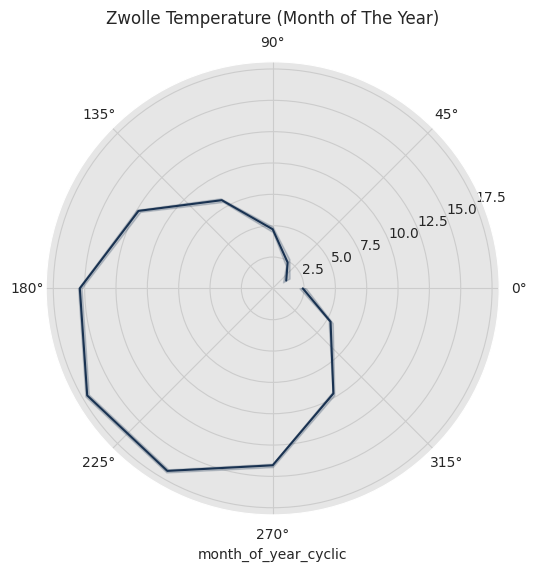

In [174]:
def plot_seasons(df, city):    
    # Polar plot for seasonality 
    ax = plt.subplot(111, projection='polar')
    daily_data_df = df[df.City==city]

    # Convert and plot data
    daily_data_df \
        .assign(month_of_year_cyclic = lambda x: x['month'].transform(lambda x: 2*np.pi*x/12)) \
        .pipe((sns.lineplot, 'data'), 
            x='month_of_year_cyclic', 
            y='AverageTemperature', 
            ax=ax
        )

    ax.set_ylabel('')
    ax.set_title(city + ' Temperature (Month of The Year)', va='bottom');

plot_seasons(df, "Zwolle")

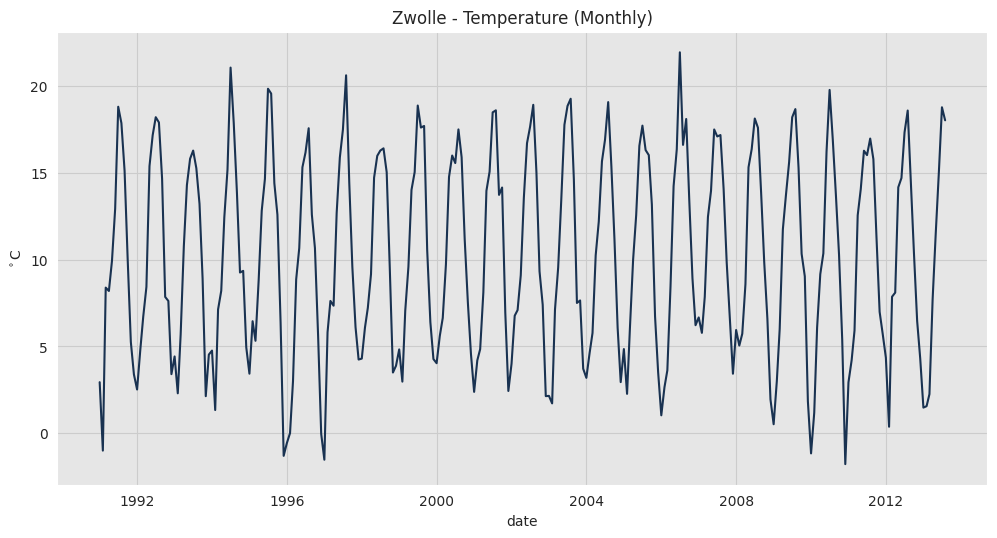

In [173]:
def plot_temp(df, city):
    daily_data_df = df[df.City==city]
    # Plot temperature on daily basis 
    fig, ax = plt.subplots()
    sns.lineplot(x='date', y='AverageTemperature', data=daily_data_df.reset_index(), ax=ax)
    ax.set(title=city + ' - Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_temp(df.query("year>1990"), "Zwolle")

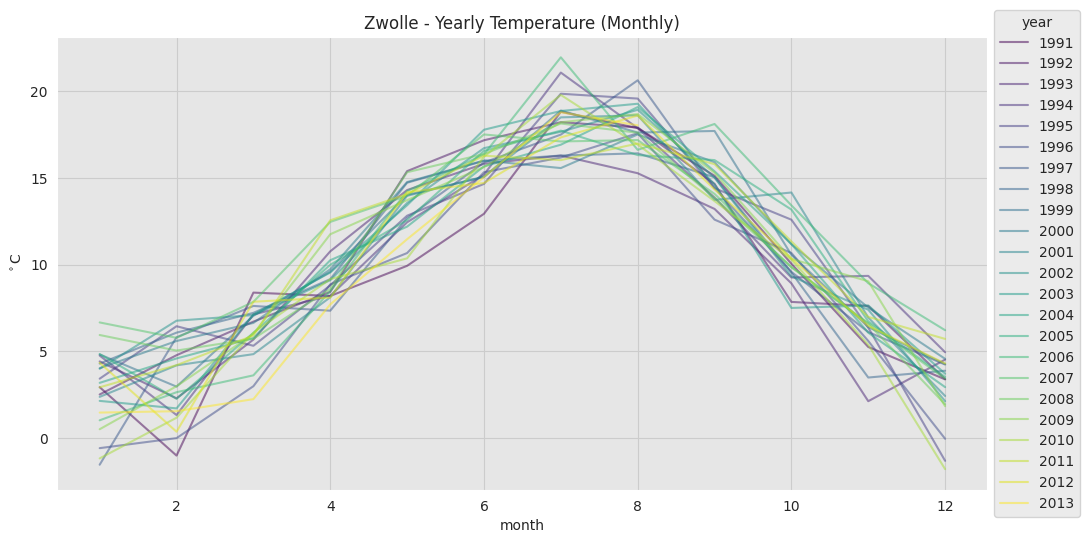

In [172]:
def plot_yearly_season(df, city):
    daily_data_df = df[df.City==city].dropna()
    # Plot yearly seasonality
    fig, ax = plt.subplots() 

    pd.pivot_table(data=daily_data_df[['year', 'month', 'AverageTemperature']], index='month', columns='year') \
        ['AverageTemperature'] \
        .plot(cmap='viridis', alpha=0.5, ax=ax)

    ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set(title=city + ' - Yearly Temperature (Monthly)', ylabel=r'$^\circ$C');

plot_yearly_season(df.query("year>1990"), "Zwolle")

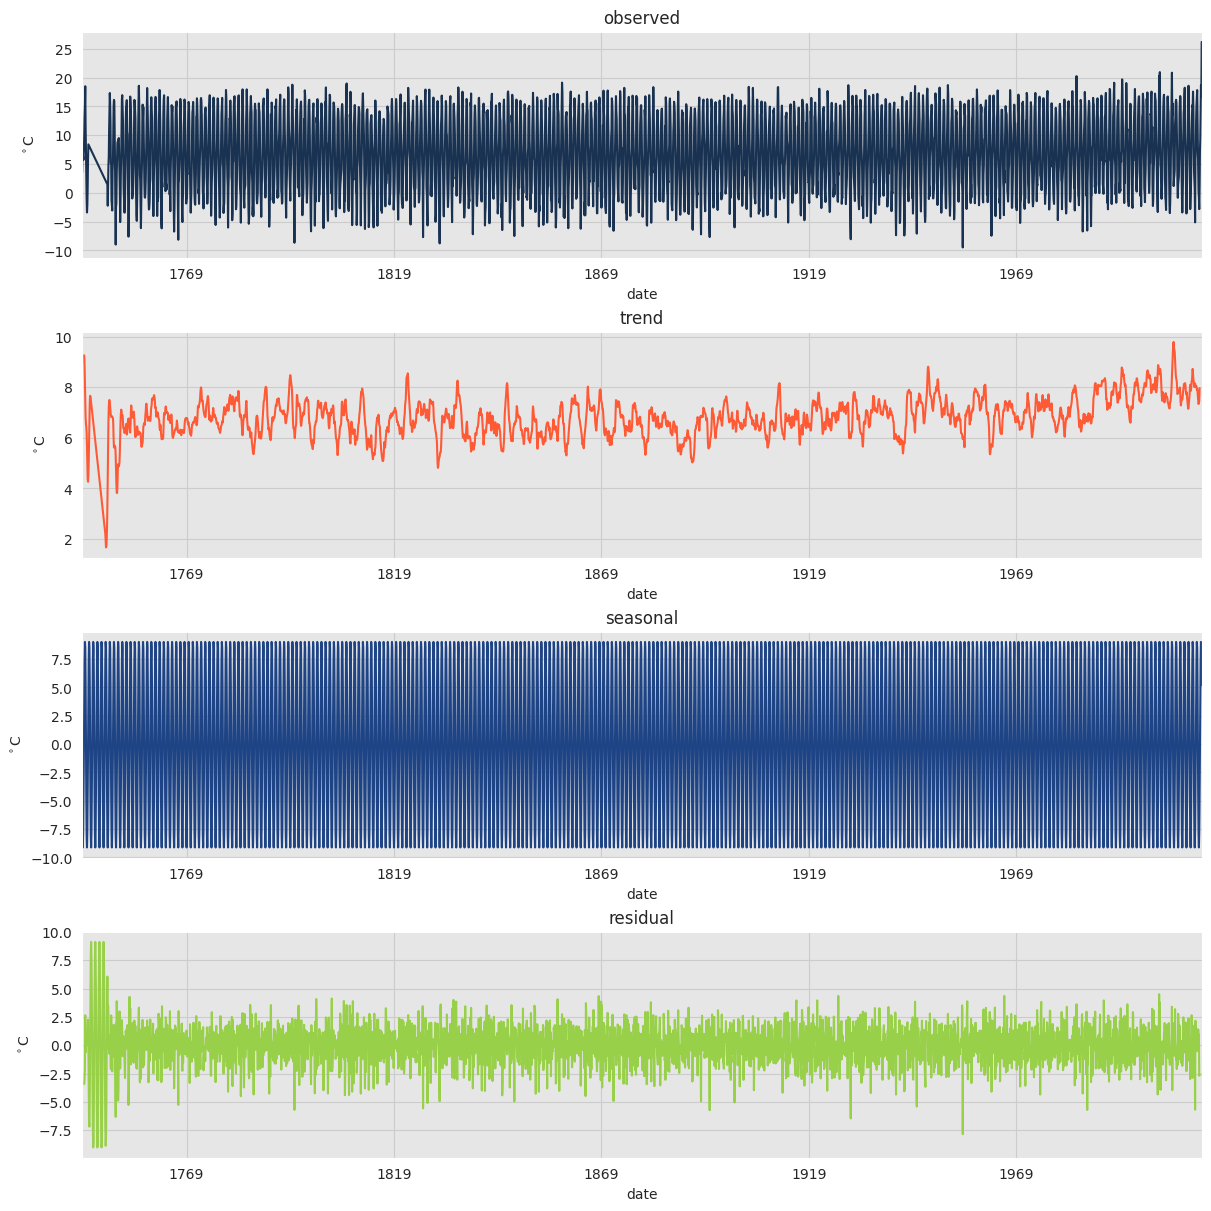

In [6]:
def trend_season_residual(df, city):
    df = df[df.City==city]
    df = df.dropna(subset=["AverageTemperature"])
    # We use the parameter `period` = 12 to extract the yearly seasonality. 
    seas_decomp_yearly = seasonal_decompose(
        x=df['AverageTemperature'], 
        model='additive', 
        period=12
    )

    # Plot data
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

    seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
    ax[0].set(title='observed', ylabel=r'$^\circ$C')
    seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
    ax[1].set(title='trend', ylabel=r'$^\circ$C')
    seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
    ax[2].set(title='seasonal', ylabel=r'$^\circ$C')
    seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
    ax[3].set(title='residual', ylabel=r'$^\circ$C');
    return seas_decomp_yearly

seas_decomb_yearly = trend_season_residual(df, "Zurich")

In [14]:
# Test for stationarity 

def stationarity_test(df):
    
    #df = df.dropna()
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = df.rolling(12).mean()
    rolling_std_dev = df.rolling(12).std()
    '''
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(df, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print('ADF Test:')
    adf_test = adfuller(df,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    '''
    # KPSS test
    print('KPSS Test:')
    kpss_test = kpss(df, regression='c', nlags='legacy', store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Critical Values:")
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))

    if kpss_test[0] < kpss_test[3]["5%"]:
        print("Reject H0 - Time Series is Stationary")
    else:
        print("Failed to Reject H0 - Time Series is Non-Stationary")
    
    print('----'*10)
    
stationarity_test(df.query('year<1950 and year>1760').AverageTemperature.squeeze())

KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 27.763634
p-value: 0.010000
Critical Values:
(27.763634102072192, 0.01, 186, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Failed to Reject H0 - Time Series is Non-Stationary
----------------------------------------


/home/rapunzel/home/projects/earth_surface_temperature/.venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [9]:
kpss_test

NameError: name 'kpss_test' is not defined

In [10]:
# From Kaggle.com
# https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.AverageTemperature, lags=60)


: 

: 

In [18]:
#df = df.assign(InterpolateTime=df.AverageTemperature.interpolate(method='time'))
df.isnull().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
year                                  0
month                                 0
day                                   0
dayofyear                             0
dtype: int64

In [21]:
df = df.assign(AverageTemperature=df.AverageTemperature.squeeze().interpolate(method='time'))
df.isnull().sum()

dt                                    0
AverageTemperature                    0
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
year                                  0
month                                 0
day                                   0
dayofyear                             0
InterpolateTime                       0
dtype: int64

In [22]:
df = df.drop(columns=["InterpolateTime"])

In [24]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month,day,dayofyear
date,,,,,,,,,,,
1743-11-01,1743-11-01,6.068000,1.737,Århus,Denmark,57.05N,10.33E,1743,11,1,305
1743-12-01,1743-12-01,7.094947,NaN,Århus,Denmark,57.05N,10.33E,1743,12,1,335
1744-01-01,1744-01-01,6.634026,NaN,Århus,Denmark,57.05N,10.33E,1744,1,1,1
1744-02-01,1744-02-01,6.173105,NaN,Århus,Denmark,57.05N,10.33E,1744,2,1,32
1744-03-01,1744-03-01,5.741921,NaN,Århus,Denmark,57.05N,10.33E,1744,3,1,61
